# E2a: Küchentischversuch zum Laval-Rotor

Name: Jakob Maurer  
Datum: 04.01.2024 

## Forschungsfrage

sind vibrationsalarme unterschiedlicher Hersteller in Frequenz und amplitude vergleichbar

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="image/mi9.JPEG" width="500">

- Beschreibung des Aufbaus: Der Beschleunigungssensor wird mit Klebeband auf der Rückseite des jeweiligen Handys besfestigt. Das Handy liegt mit dem Display auf der Tischplatte
- Vorgangsbeschreibung: Der Vibrationsarlarm des Weckers wird gestartet und die Beschleunigungen vom Sensor aufgenommen. Die Messung startet erst nachdem der Alarm gestartet hat.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [77]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [78]:
"""Parameter definition"""

path_measurement_folder = "measurement_data/data_20240104_162811_Jakob Maurer_mi9"
h5_file_name = "data_20240104_162811_Jakob Maurer_mi9.h5" # 
# ---------------------------------------------------------------------------------------------#1-end

In [79]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240104_162811_Jakob Maurer_mi9/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240104_162811_Jakob Maurer_mi9/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240104_162811_Jakob Maurer_mi9/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeaaf21-69a8-6d69-99c8-20445829a5ab": {
    "type": "probe",
    "name": "mi9",
    "comment": "",
    "path": "measurement_data/data_20240104_

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [80]:
with h5py.File(path_measurement_folder+"/"+h5_file_name,"r") as data:
    # Messdaten auslesen und die jeweilige beschleunigung in Liste speichern
    a_x = np.array(data["RawData"][sensor_settings_dict["ID"]]["acceleration_x"])
    a_y = np.array(data["RawData"][sensor_settings_dict["ID"]]["acceleration_y"])
    a_z = np.array(data["RawData"][sensor_settings_dict["ID"]]["acceleration_z"])
    time = np.array(data["RawData"][sensor_settings_dict["ID"]]["timestamp"])
    data.close()

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [81]:
a = get_vec_accel(a_x, a_y, a_z)
#gesamtbeschleunigung berechnet

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0.5, 0, 'Zeit in s')

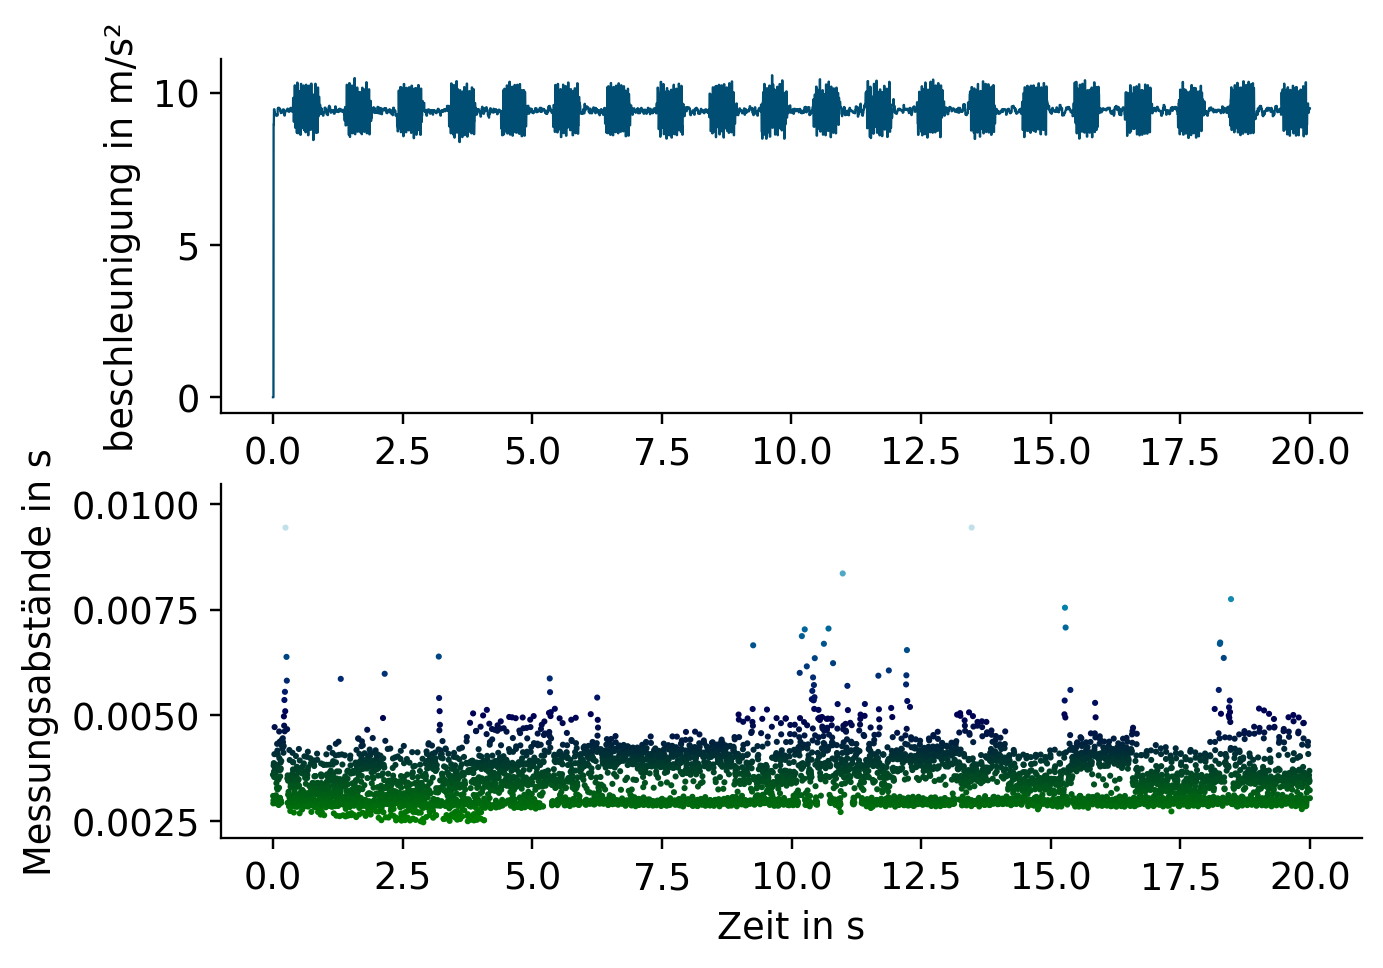

In [82]:
plt.figure(1)
#Plot Beschleunigung über zeit
plt.subplot(211)
plt.plot(time, a)
plt.ylabel("beschleunigung in m/s²")
plt.xlabel("Zeit in s")
plt.subplot(212)
#PLot Zeitabstände über Zeit
dtime=[]
for i in range(len(time)-1):
    dtime.append(time[i+1]-time[i]) # Zeitabstände berechnen
plt.scatter(time[:-1],dtime, s=1,c=dtime,cmap="ocean")
plt.ylabel("Messungsabstände in s")
plt.xlabel("Zeit in s")

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [83]:
# -------------------------------------------------------------------------------------------#4-start
interpolation_messdaten = interpolation(time,a)



#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

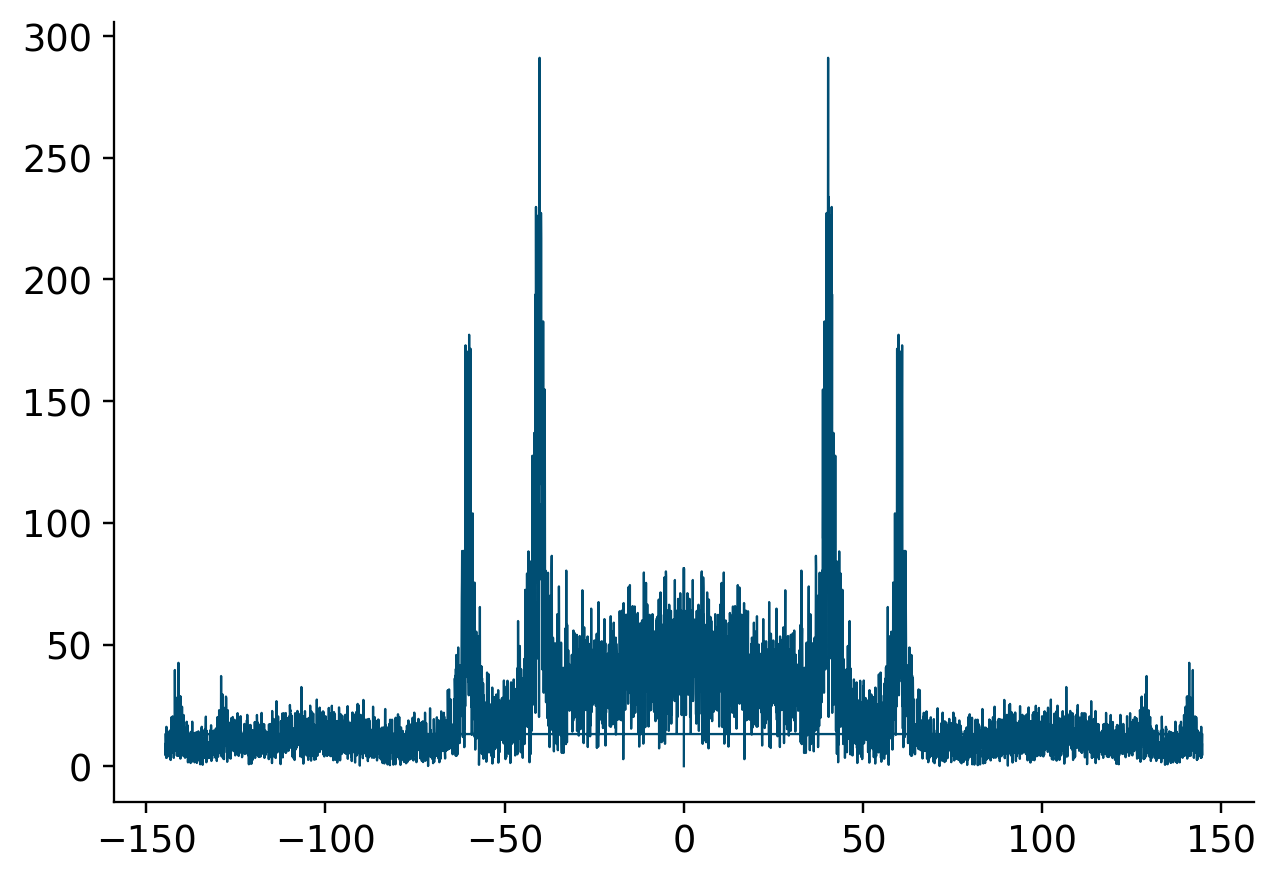

In [84]:
# -------------------------------------------------------------------------------------------#5-start
daten=my_fft(interpolation_messdaten,time)

plt.plot(daten[1],daten[0])
#Amplitude wird über frequenz geplotted
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="image/iphone.jpg" width="500">

- Beschreibung des Aufbaus: der gleiche aufbau wie beim ersten versuch
- Vorgangsbeschreibung:um die daten der beiden handys vergleichabr zu gestalten wird der Versuch genauso wie Versuch 1 durchgeführt

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [85]:
path_measurement_folder = "measurement_data/data_20240104_163625_Jakob Maurer_iphone"
h5_file_name = "data_20240104_163625_Jakob Maurer_iphone.h5" 

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [86]:
with h5py.File(path_measurement_folder+"/"+h5_file_name,"r") as data:
    #Daten werden abgerufen und in Listen gespeichert
    a_x = np.array(data["RawData"][sensor_settings_dict["ID"]]["acceleration_x"])
    a_y = np.array(data["RawData"][sensor_settings_dict["ID"]]["acceleration_y"])
    a_z = np.array(data["RawData"][sensor_settings_dict["ID"]]["acceleration_z"])
    time = np.array(data["RawData"][sensor_settings_dict["ID"]]["timestamp"])
    data.close()

#### 2. Betrag der Beschleunigung berechnen


In [87]:
a = get_vec_accel(a_x, a_y, a_z)


#### 3. Darstellung der Messdaten

Text(0.5, 0, 'Zeit in s')

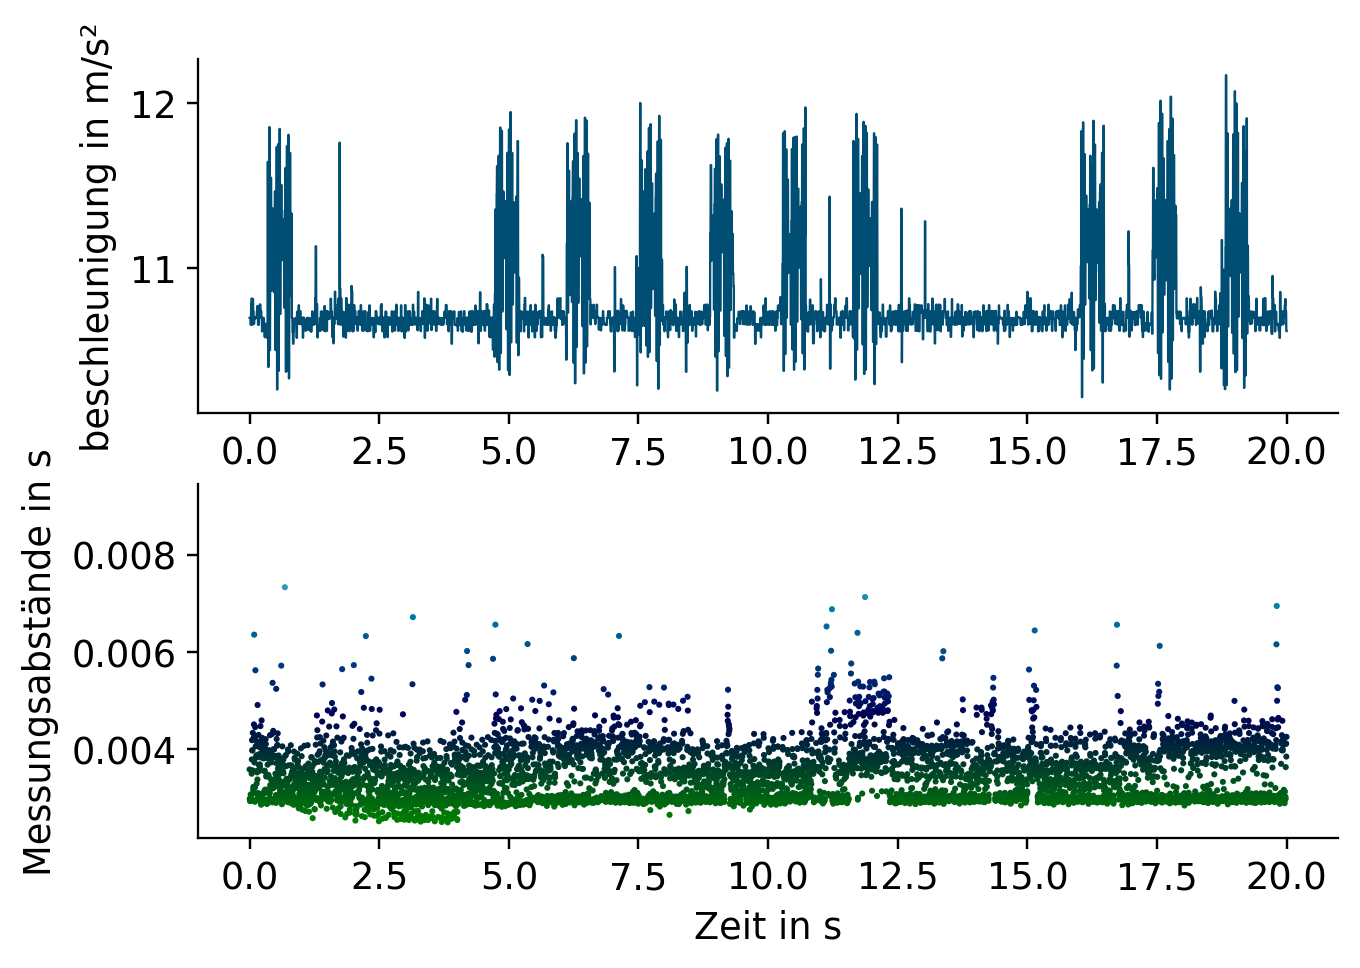

In [88]:
# beschleunigung über Zeit plot
plt.figure(1)
plt.subplot(211)
plt.plot(time, a)
plt.ylabel("beschleunigung in m/s²")
plt.xlabel("Zeit in s")
plt.subplot(212)
# Zeitabstände über Zeit Plot
dtime=[]
for i in range(len(time)-1):
    dtime.append(time[i+1]-time[i])
plt.scatter(time[:-1],dtime, s=1,c=dtime,cmap="ocean")
plt.ylabel("Messungsabstände in s")
plt.xlabel("Zeit in s")

#### 4. Interpolation der Messwerte



In [89]:
interpolation_messdaten = interpolation(time,a)

#### 5 & 6. FFT durchführen und graphisch darstellen


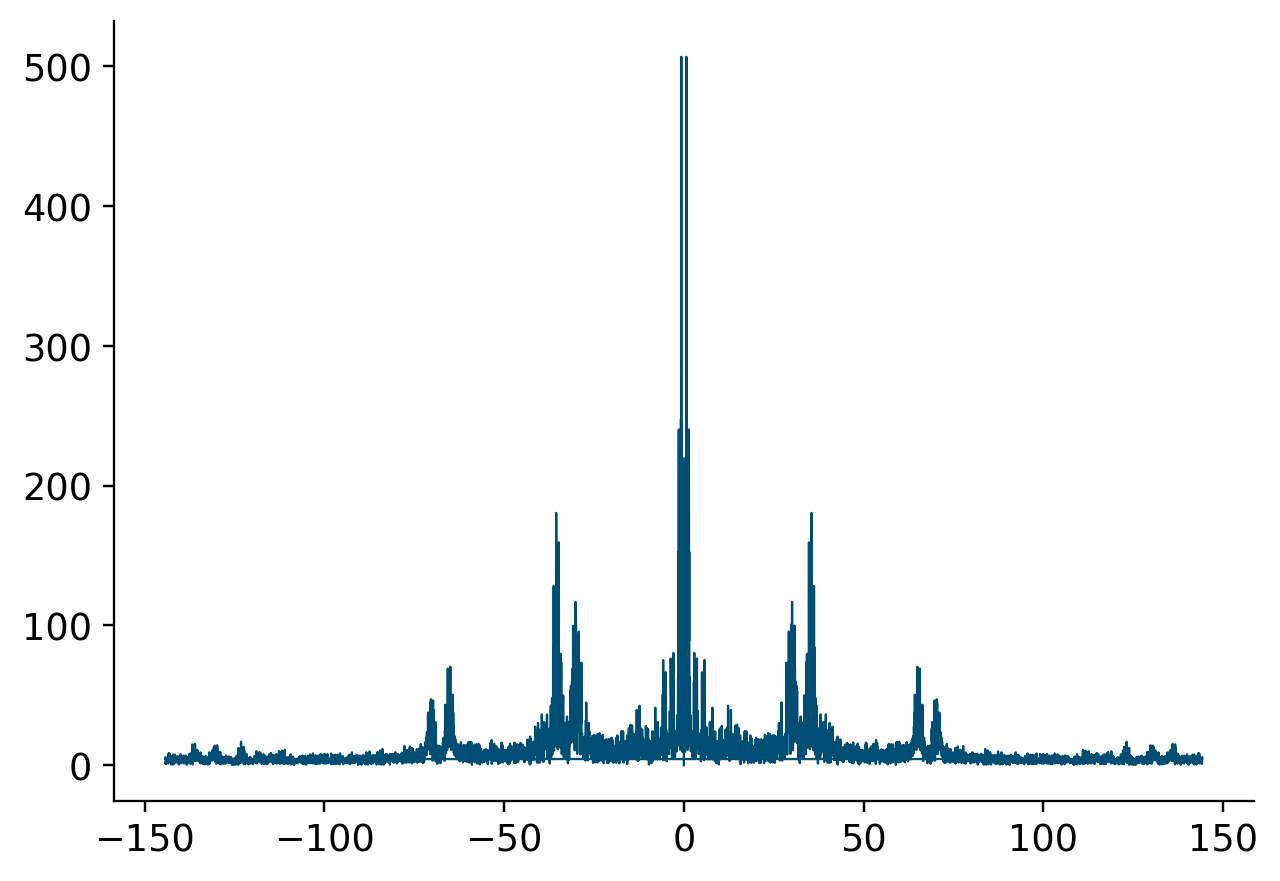

In [90]:
daten=my_fft(interpolation_messdaten,time)

plt.plot(daten[1],daten[0])

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Da die Vibrationsintervalle unterschiedlich waren lässt sich keine direkte Aussage treffen. Jedoch sind die Frequenzen in ähnlichen bereichen angesiedelt. Ein durchgehendes Vibrieren wäre für einen Vergleich deutlich hilfreicher gewesen. Die übergeordneten Muster der Alarme stören die Messung etwas und führen zu einer höheren Vielfalt an Frequenzen.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der Versuch war gut durchzuführen und die Aufgabenstellung war eindeutig. Leider sind die Graphen und endergebnisse nicht besonders Aussagekräftig oder intuitiv verständlich. Damit war es schwer festzustellen ob mathematische Fehler beim interpolieren oder beim übertragen in den Frequenzbereich passiert sind.